In [74]:
import pandas as pd
import random
import os
import numpy as np
from tqdm import tqdm
import time

from matplotlib import font_manager, rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import combinations
from scipy.stats.mstats import gmean
from sklearn.metrics import roc_auc_score

In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [5]:
train.shape, test.shape

((30200, 14), (12943, 13))

In [6]:
for col in train.columns:
    if col not in test.columns:
        print(col)

전화해지여부


#### Dataset Info.

- train.csv
    - 30200개의 데이터
    - ID : 샘플 별 고유 ID
    - 가입일 : 서비스에 가입한 일수
    - 음성사서함이용 : 음성사서함 이용 건수
    - 주간통화시간 : 8시 ~ 16시까지의 통화 시간
    - 주간통화횟수 : 8시 ~ 16시까지의 통화 횟수
    - 주간통화요금 : 8시 ~ 16시까지의 통화 요금
    - 저녁통화시간 : 16시 ~ 0시까지의 통화 시간
    - 저녁통화횟수 : 16시 ~ 0시까지의 통화 횟수
    - 저녁통화요금 : 16시 ~ 0시까지의 통화 요금
    - 밤통화시간 : 0시 ~ 8시까지의 통화 시간
    - 밤통화횟수 : 0시 ~ 8시까지의 통화 횟수
    - 밤통화요금 : 0시 ~ 8시까지의 통화 요금
    - 상담전화건수 : 고객센터에 전화를 건 횟수
    - 전화해지여부 : 0(서비스 유지)/ 1(서비스 해지) 

- test.csv
    - 12943개의 데이터
    - ID : 샘플 별 고유 ID
    - 가입일 : 서비스에 가입한 일수
    - 음성사서함이용 : 음성사서함 이용 건수
    - 주간통화시간 : 8시 ~ 16시까지의 통화 시간
    - 주간통화횟수 : 8시 ~ 16시까지의 통화 횟수
    - 주간통화요금 : 8시 ~ 16시까지의 통화 요금
    - 저녁통화시간 : 16시 ~ 0시까지의 통화 시간
    - 저녁통화횟수 : 16시 ~ 0시까지의 통화 횟수
    - 저녁통화요금 : 16시 ~ 0시까지의 통화 요금
    - 밤통화시간 : 0시 ~ 8시까지의 통화 시간
    - 밤통화횟수 : 0시 ~ 8시까지의 통화 횟수
    - 밤통화요금 : 0시 ~ 8시까지의 통화 요금
    - 상담전화건수 : 고객센터에 전화를 건 횟수

- sample_submission.csv [제출양식]
    - ID : 샘플 별 고유 ID
    - 전화해지여부 : 0(서비스 유지)/ 1(서비스 해지)

In [7]:
data = pd.concat([train,test],axis=0)

<Axes: >

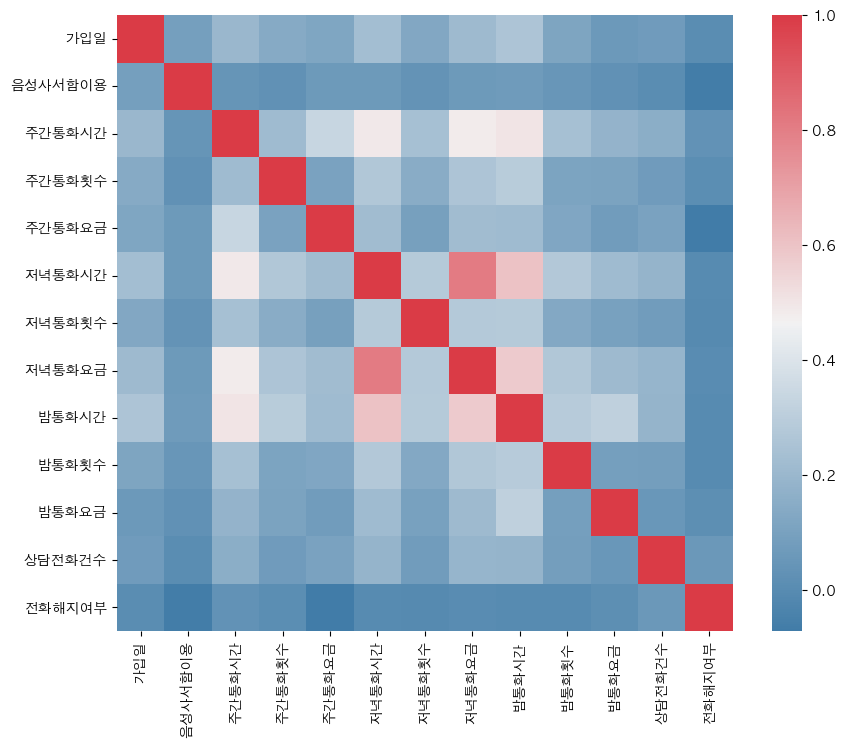

In [8]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

In [9]:
data['통화시간'] = data['주간통화시간'] + data['저녁통화시간'] + data['밤통화시간']
data['통화횟수'] = data['주간통화횟수'] + data['저녁통화횟수'] + data['밤통화횟수']
data['통화요금'] = data['주간통화요금'] + data['저녁통화요금'] + data['밤통화요금']

In [10]:
data['음성사서함이용_ratio'] = data['음성사서함이용']/data['가입일']
data['주간통화시간_ratio'] = data['주간통화시간']/data['가입일']
data['주간통화횟수_ratio'] = data['주간통화횟수']/data['가입일']
data['주간통화요금_ratio'] = data['주간통화요금']/data['가입일']
data['저녁통화시간_ratio'] = data['저녁통화시간']/data['가입일']
data['저녁통화횟수_ratio'] = data['저녁통화횟수']/data['가입일']
data['저녁통화요금_ratio'] = data['저녁통화요금']/data['가입일']
data['밤통화시간_ratio'] = data['밤통화시간']/data['가입일']
data['밤통화요금_ratio'] = data['밤통화요금']/data['가입일']
data['상담전화건수_ratio'] = data['상담전화건수']/data['가입일']
data['통화시간_ratio'] = data['통화시간']/data['가입일']
data['통화횟수_ratio'] = data['통화횟수']/data['가입일']
data['통화요금_ratio'] = data['통화요금']/data['가입일']

In [11]:
# data = data.drop(['저녁통화시간'],axis=1)

In [12]:
data.columns

Index(['ID', '가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간',
       '저녁통화횟수', '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '전화해지여부',
       '통화시간', '통화횟수', '통화요금', '음성사서함이용_ratio', '주간통화시간_ratio', '주간통화횟수_ratio',
       '주간통화요금_ratio', '저녁통화시간_ratio', '저녁통화횟수_ratio', '저녁통화요금_ratio',
       '밤통화시간_ratio', '밤통화요금_ratio', '상담전화건수_ratio', '통화시간_ratio',
       '통화횟수_ratio', '통화요금_ratio'],
      dtype='object')

In [13]:
data.corr()['전화해지여부'].sort_values()

주간통화요금          -0.071006
음성사서함이용         -0.062734
통화요금            -0.051642
음성사서함이용_ratio   -0.035821
주간통화요금_ratio    -0.018266
통화요금_ratio      -0.011799
주간통화횟수_ratio    -0.006655
저녁통화횟수_ratio    -0.005012
통화횟수_ratio      -0.004652
저녁통화횟수          -0.004276
저녁통화시간_ratio    -0.003415
밤통화횟수           -0.003121
밤통화시간           -0.002872
저녁통화요금_ratio    -0.002703
통화시간_ratio      -0.001358
밤통화시간_ratio     -0.001280
저녁통화시간          -0.000163
밤통화요금_ratio      0.000144
주간통화시간_ratio     0.000756
저녁통화요금           0.001711
통화횟수             0.001818
가입일              0.006688
주간통화횟수           0.010974
통화시간             0.011960
밤통화요금            0.014513
상담전화건수_ratio     0.021148
주간통화시간           0.029975
상담전화건수           0.057114
전화해지여부           1.000000
Name: 전화해지여부, dtype: float64

In [14]:
data.corr()['저녁통화시간'].sort_values()

전화해지여부          -0.000163
음성사서함이용_ratio    0.010748
주간통화요금_ratio     0.010893
상담전화건수_ratio     0.014029
주간통화횟수_ratio     0.018590
주간통화시간_ratio     0.020240
밤통화시간_ratio      0.021213
밤통화요금_ratio      0.021660
저녁통화횟수_ratio     0.022638
통화횟수_ratio       0.024406
통화요금_ratio       0.027161
통화시간_ratio       0.038524
저녁통화요금_ratio     0.058997
음성사서함이용          0.066819
저녁통화시간_ratio     0.070597
상담전화건수           0.186747
밤통화요금            0.216575
주간통화요금           0.217735
가입일              0.228065
주간통화횟수           0.272014
밤통화횟수            0.275454
저녁통화횟수           0.281625
통화횟수             0.426014
통화요금             0.472881
주간통화시간           0.491023
밤통화시간            0.602983
저녁통화요금           0.809164
통화시간             0.831078
저녁통화시간           1.000000
Name: 저녁통화시간, dtype: float64

In [15]:
train = data.iloc[:30200]
test = data.iloc[30200:]

In [16]:
del test['전화해지여부']

In [18]:
train.columns

Index(['ID', '가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간',
       '저녁통화횟수', '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '전화해지여부',
       '통화시간', '통화횟수', '통화요금', '음성사서함이용_ratio', '주간통화시간_ratio', '주간통화횟수_ratio',
       '주간통화요금_ratio', '저녁통화시간_ratio', '저녁통화횟수_ratio', '저녁통화요금_ratio',
       '밤통화시간_ratio', '밤통화요금_ratio', '상담전화건수_ratio', '통화시간_ratio',
       '통화횟수_ratio', '통화요금_ratio'],
      dtype='object')

In [19]:
train.head(3)

,ID,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,...,주간통화요금_ratio,저녁통화시간_ratio,저녁통화횟수_ratio,저녁통화요금_ratio,밤통화시간_ratio,밤통화요금_ratio,상담전화건수_ratio,통화시간_ratio,통화횟수_ratio,통화요금_ratio
0,TRAIN_00000,329,0,99.2,93,27.3,268.8,68,28.92,262.9,...,0.082979,0.817021,0.206687,0.087903,0.799088,0.099970,0.006079,1.917629,1.486322,0.270851
1,TRAIN_00001,2,80,323.9,323,83.7,269.4,326,32.09,322.8,...,41.850000,134.700000,163.000000,16.045000,161.400000,16.160000,1.000000,458.050000,429.000000,74.055000
2,TRAIN_00002,93,28,282.4,323,34.2,207.0,322,32.82,280.8,...,0.367742,2.225806,3.462366,0.352903,3.019355,0.089032,0.000000,8.281720,10.462366,0.809677


In [20]:
# nan 값 0개

train.isnull().sum()

ID               0
가입일              0
음성사서함이용          0
주간통화시간           0
주간통화횟수           0
주간통화요금           0
저녁통화시간           0
저녁통화횟수           0
저녁통화요금           0
밤통화시간            0
밤통화횟수            0
밤통화요금            0
상담전화건수           0
전화해지여부           0
통화시간             0
통화횟수             0
통화요금             0
음성사서함이용_ratio    0
주간통화시간_ratio     0
주간통화횟수_ratio     0
주간통화요금_ratio     0
저녁통화시간_ratio     0
저녁통화횟수_ratio     0
저녁통화요금_ratio     0
밤통화시간_ratio      0
밤통화요금_ratio      0
상담전화건수_ratio     0
통화시간_ratio       0
통화횟수_ratio       0
통화요금_ratio       0
dtype: int64

In [21]:
test.isnull().sum()

ID               0
가입일              0
음성사서함이용          0
주간통화시간           0
주간통화횟수           0
주간통화요금           0
저녁통화시간           0
저녁통화횟수           0
저녁통화요금           0
밤통화시간            0
밤통화횟수            0
밤통화요금            0
상담전화건수           0
통화시간             0
통화횟수             0
통화요금             0
음성사서함이용_ratio    0
주간통화시간_ratio     0
주간통화횟수_ratio     0
주간통화요금_ratio     0
저녁통화시간_ratio     0
저녁통화횟수_ratio     0
저녁통화요금_ratio     0
밤통화시간_ratio      0
밤통화요금_ratio      0
상담전화건수_ratio     0
통화시간_ratio       0
통화횟수_ratio       0
통화요금_ratio       0
dtype: int64

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 0 to 30199
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             30200 non-null  object 
 1   가입일            30200 non-null  int64  
 2   음성사서함이용        30200 non-null  int64  
 3   주간통화시간         30200 non-null  float64
 4   주간통화횟수         30200 non-null  int64  
 5   주간통화요금         30200 non-null  float64
 6   저녁통화시간         30200 non-null  float64
 7   저녁통화횟수         30200 non-null  int64  
 8   저녁통화요금         30200 non-null  float64
 9   밤통화시간          30200 non-null  float64
 10  밤통화횟수          30200 non-null  int64  
 11  밤통화요금          30200 non-null  float64
 12  상담전화건수         30200 non-null  int64  
 13  전화해지여부         30200 non-null  float64
 14  통화시간           30200 non-null  float64
 15  통화횟수           30200 non-null  int64  
 16  통화요금           30200 non-null  float64
 17  음성사서함이용_ratio  30200 non-null  float64
 18  주간통화시간

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12943 entries, 0 to 12942
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             12943 non-null  object 
 1   가입일            12943 non-null  int64  
 2   음성사서함이용        12943 non-null  int64  
 3   주간통화시간         12943 non-null  float64
 4   주간통화횟수         12943 non-null  int64  
 5   주간통화요금         12943 non-null  float64
 6   저녁통화시간         12943 non-null  float64
 7   저녁통화횟수         12943 non-null  int64  
 8   저녁통화요금         12943 non-null  float64
 9   밤통화시간          12943 non-null  float64
 10  밤통화횟수          12943 non-null  int64  
 11  밤통화요금          12943 non-null  float64
 12  상담전화건수         12943 non-null  int64  
 13  통화시간           12943 non-null  float64
 14  통화횟수           12943 non-null  int64  
 15  통화요금           12943 non-null  float64
 16  음성사서함이용_ratio  12943 non-null  float64
 17  주간통화시간_ratio   12943 non-null  float64
 18  주간통화횟수

In [24]:
train.describe()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,...,주간통화요금_ratio,저녁통화시간_ratio,저녁통화횟수_ratio,저녁통화요금_ratio,밤통화시간_ratio,밤통화요금_ratio,상담전화건수_ratio,통화시간_ratio,통화횟수_ratio,통화요금_ratio
count,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,...,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,159.732649,12.037815,250.563457,159.175728,41.091447,263.247215,158.474536,25.394260,263.438285,157.047417,...,0.597957,3.812911,2.223489,0.363750,3.753953,0.174208,0.033108,11.188845,6.720993,1.135915
std,123.752781,24.925334,84.403350,101.573057,23.179017,74.064922,102.200293,8.146126,73.778416,101.721601,...,1.479318,7.604833,4.719600,0.694564,7.269223,0.424331,0.095500,21.891108,13.136578,2.443968
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,20.800000,20.000000,...,0.000000,0.001075,0.000000,0.000000,0.085321,0.001049,0.000000,0.303573,0.150158,0.018834
25%,63.000000,0.000000,222.800000,88.000000,24.400000,223.700000,87.000000,22.220000,223.700000,87.000000,...,0.125091,1.017083,0.467662,0.100270,1.018182,0.032200,0.006920,3.097586,1.918008,0.293692
50%,118.000000,1.000000,234.000000,117.500000,30.800000,243.000000,112.000000,23.320000,242.800000,108.000000,...,0.293403,1.618906,1.000000,0.143654,1.587917,0.089694,0.009852,4.862907,2.956989,0.554068
75%,228.000000,22.000000,289.600000,223.000000,45.900000,290.300000,223.000000,28.820000,290.500000,222.000000,...,0.706154,4.607035,2.397849,0.443716,4.536825,0.148387,0.035242,13.282557,7.670959,1.412077
max,2212.000000,1112.000000,481.900000,489.000000,118.600000,481.600000,489.000000,49.980000,481.800000,490.000000,...,45.350000,161.900000,163.000000,16.445000,219.500000,16.160000,5.000000,488.900000,429.000000,74.055000


In [25]:
test.describe()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,...,주간통화요금_ratio,저녁통화시간_ratio,저녁통화횟수_ratio,저녁통화요금_ratio,밤통화시간_ratio,밤통화요금_ratio,상담전화건수_ratio,통화시간_ratio,통화횟수_ratio,통화요금_ratio
count,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,...,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000,12943.000000
mean,159.776713,12.312756,251.066221,159.761724,40.887059,263.656424,159.628216,25.440460,264.052963,157.692112,...,0.572084,3.703347,2.165384,0.354223,3.645003,0.170983,0.031976,10.857426,6.553465,1.097291
std,118.383432,28.069438,85.236623,103.648878,23.062830,75.232035,103.417132,8.288719,74.877379,101.640429,...,1.310175,6.824880,4.262587,0.623297,6.208915,0.376865,0.078011,19.040908,12.051997,2.170250
min,2.000000,0.000000,0.200000,0.000000,0.100000,0.200000,0.000000,0.000000,21.300000,20.000000,...,0.000493,0.002128,0.000000,0.000000,0.077972,0.001900,0.000000,0.303752,0.149186,0.019340
25%,63.000000,0.000000,222.700000,88.000000,24.400000,223.800000,87.000000,22.220000,223.700000,86.000000,...,0.124215,1.014418,0.485149,0.100337,1.017674,0.032045,0.006920,3.085987,1.947368,0.290403
50%,119.000000,1.000000,234.000000,115.000000,30.800000,242.700000,113.000000,23.300000,242.800000,111.000000,...,0.294382,1.597525,1.000000,0.142266,1.574038,0.089515,0.009901,4.795798,2.943478,0.552489
75%,228.000000,22.000000,289.800000,223.000000,45.900000,290.350000,223.000000,28.820000,290.700000,223.000000,...,0.703078,4.593700,2.397849,0.438974,4.557604,0.148710,0.035242,13.198837,7.558081,1.401697
max,2212.000000,1112.000000,481.800000,489.000000,118.100000,481.500000,490.000000,49.990000,481.700000,489.000000,...,45.400000,147.650000,114.500000,14.610000,146.550000,11.110000,4.000000,432.950000,340.000000,63.955000


In [75]:
from sklearn.inspection import permutation_importance # sklearn 22 버전부터 해당
from sklearn.metrics import make_scorer

# MAPE
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# fix_model : 훈련된 모델
# X_train : 훈련데이터 Feature
# y_train : 훈련데이터 Target
# scoring : Feature 를 Shuffler 한 뒤, 예측값과 실제값을 어떤 Metric 을 사용해 비교할지
# n_repeats : 특정 Feature 를 몇번 Shuffle 할 것인지
# random_state : 난수 고정
result = permutation_importance(model, X_tmk, y_tmk, scoring = make_scorer(mean_absolute_percentage_error,greater_is_better=False),
                            n_repeats=30,
                            random_state=0)
# Feature label
Feature = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc']] 

# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장
sorted_result = result.importances_mean.argsort()

# 결과를 DataFrame 화
importances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   
importances

NameError: name 'model' is not defined

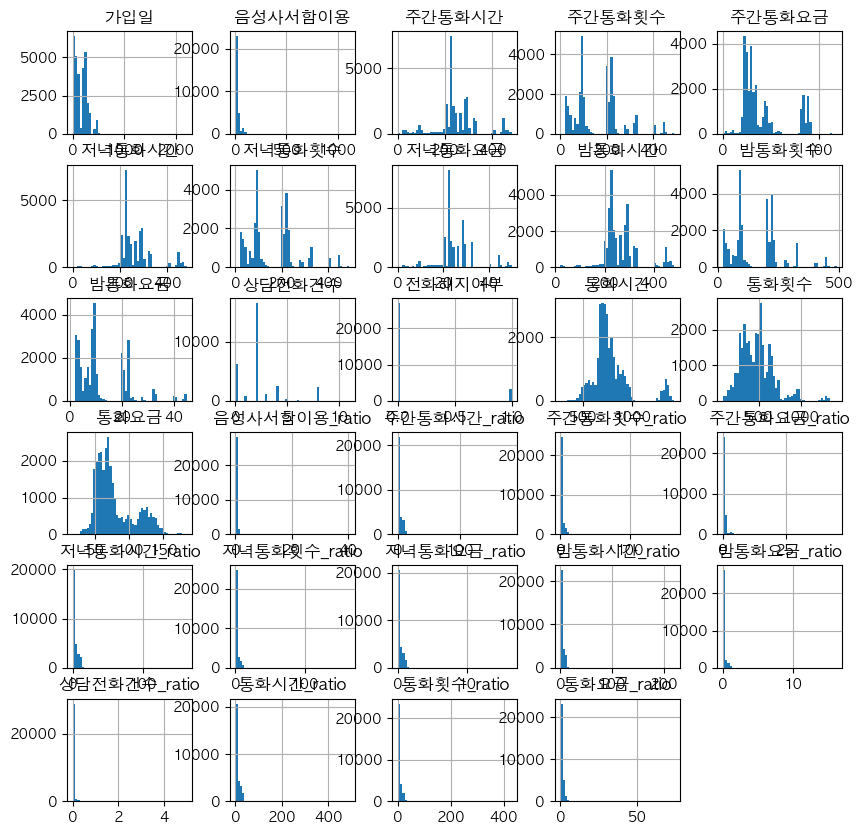

In [27]:
train.hist(bins=50, figsize=(10, 10))
plt.show()

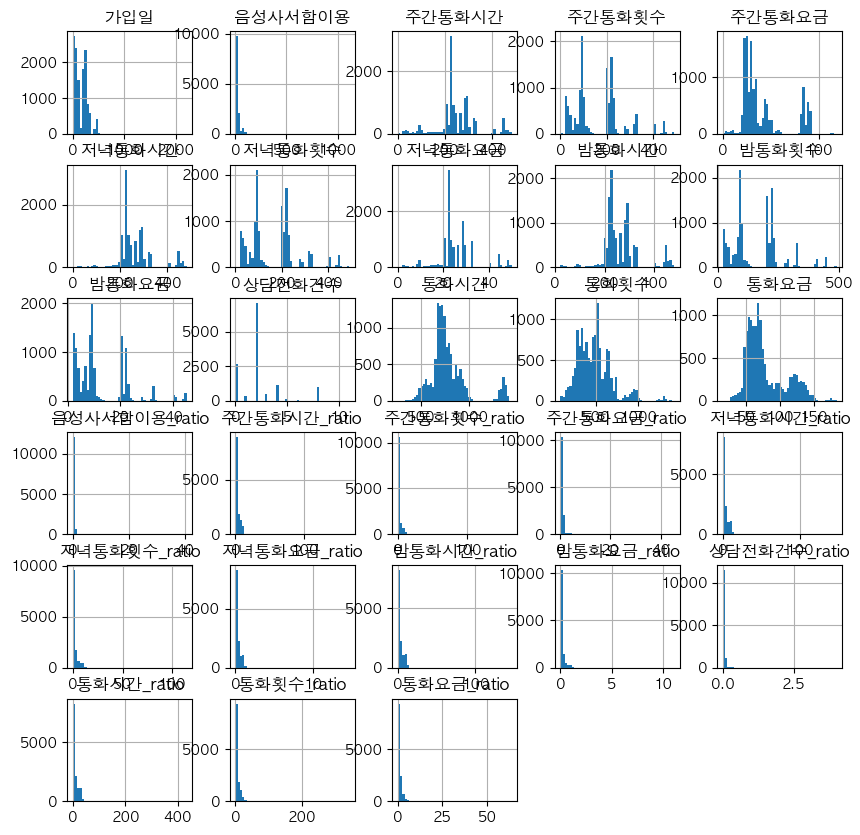

In [28]:
test.hist(bins=50, figsize=(10, 10))
plt.show()

In [29]:
corr_matrix = train.corr()

<Axes: >

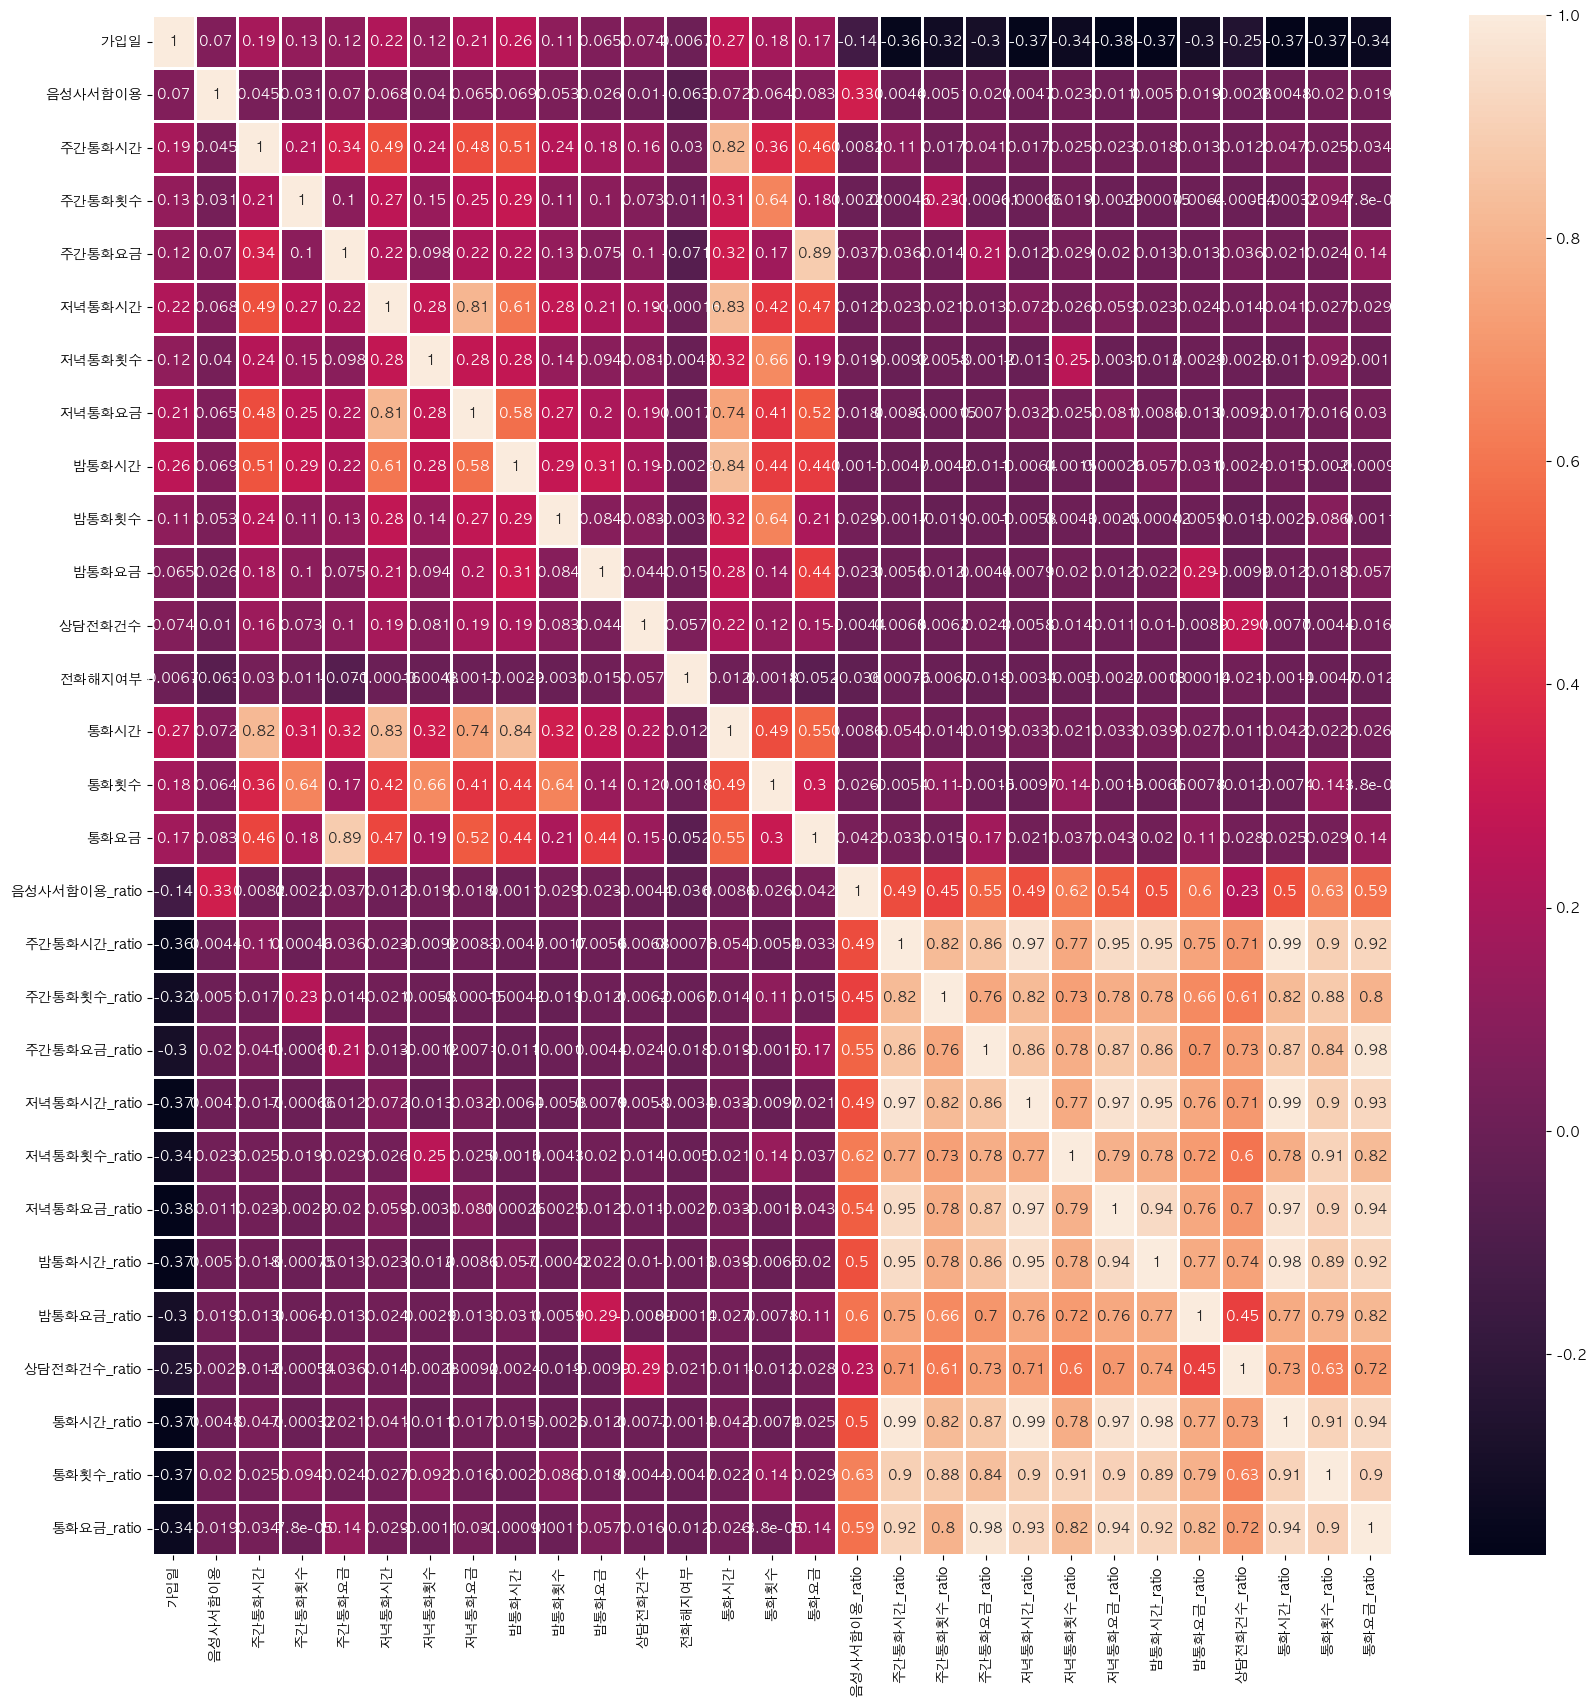

In [30]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidth=1)

In [31]:
corr_matrix['전화해지여부'].sort_values(ascending=False)

전화해지여부           1.000000
상담전화건수           0.057114
주간통화시간           0.029975
상담전화건수_ratio     0.021148
밤통화요금            0.014513
통화시간             0.011960
주간통화횟수           0.010974
가입일              0.006688
통화횟수             0.001818
저녁통화요금           0.001711
주간통화시간_ratio     0.000756
밤통화요금_ratio      0.000144
저녁통화시간          -0.000163
밤통화시간_ratio     -0.001280
통화시간_ratio      -0.001358
저녁통화요금_ratio    -0.002703
밤통화시간           -0.002872
밤통화횟수           -0.003121
저녁통화시간_ratio    -0.003415
저녁통화횟수          -0.004276
통화횟수_ratio      -0.004652
저녁통화횟수_ratio    -0.005012
주간통화횟수_ratio    -0.006655
통화요금_ratio      -0.011799
주간통화요금_ratio    -0.018266
음성사서함이용_ratio   -0.035821
통화요금            -0.051642
음성사서함이용         -0.062734
주간통화요금          -0.071006
Name: 전화해지여부, dtype: float64

- scaling 확인
- 파생 변수 만들기
- 데이터 불균형

In [35]:
# 예측에 도움이 될 수 없는 ID 컬럼을 제거합니다.
# x_train은 독립변수이므로 종속변수를 제거합니다.
X = train.drop(['ID', '전화해지여부'], axis = 1)

# y_train은 종속변수의 값을 설정해줍니다.
Y = train['전화해지여부']

# test 데이터에서 예측에 도움이 될 수 없는 ID 컬럼을 제거합니다.
test = test.drop('ID', axis = 1)

In [41]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import *
from imblearn.combine import SMOTETomek

In [45]:
# SMOTE
smote = SMOTE()
X_smo , y_smo = smote.fit_resample(X,Y)


# TomekLinks
tmk = TomekLinks(sampling_strategy='majority')
X_tmk, y_tmk = tmk.fit_resample(X, Y)

# SMOTE-Tomek
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_smotmk, Y_smotmk = smoteto.fit_resample(X, Y)

In [61]:
def split(X,Y):
    from sklearn.model_selection import train_test_split
    X_train, X_dev, y_train, y_dev = train_test_split(X, Y, stratify=Y, random_state=42)
    return X_train, X_dev, y_train, y_dev

In [62]:
X_train, X_dev, y_train, y_dev = split(X,Y)

In [43]:
Y.value_counts()

0.0    26882
1.0     3318
Name: 전화해지여부, dtype: int64

In [46]:
Y_smotmk.value_counts()

1.0    26882
0.0    26654
Name: 전화해지여부, dtype: int64

In [52]:
print(X.shape)
print(Y.shape)

print(X_tmk.shape)
print(y_tmk.shape)

# print(X_tmktmk.shape)
# print(y_tmktmk.shape)

print(X_smo.shape)
print(y_smo.shape)

(30200, 28)
(30200,)
(29479, 28)
(29479,)
(53764, 28)
(53764,)


In [63]:
print(X_train.shape)
print(y_train.shape)

print(X_dev.shape)
print(y_dev.shape)

(22650, 28)
(22650,)
(7550, 28)
(7550,)


In [64]:
clfs = [
    (
        CatBoostClassifier(random_state=0),
        {'iterations' : [125,150,175]}
    ),
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [11,13,15,17,19],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': ['auto', 32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
#     (
#         SVC(probability= True, random_state=0),
#         {'C': [1],         
#          'kernel': ['linear'],
#          'gamma': ['scale'],
#         }
#     ),  
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [None,3,4,5],
        'max_features': (np.arange(0.5, 1.0, 0.1)*X_tmk.shape[1]).astype(int)}
    ),
    (
        LGBMClassifier(random_state=0),
        {'bagging_fraction': (0.5,0.8,0.1),
         'bagging_frequency': (5, 8),
         'feature_fraction': (0.5, 0.8),
         'max_depth': (10, 13),
         'min_data_in_leaf': (90, 120),
         'num_leaves': (1200, 1550)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'loss' : ["deviance"],
         'n_estimators' : [100],
         'learning_rate': [0.1, 0.05, 0.01],
         'max_depth': [4],
         'min_samples_leaf': [100,150],
        #  'max_features': [0.3, 0.1]}
        'max_features': (np.arange(0.5, 1.0, 0.1)*X_tmk.shape[1]).astype(int)}
    ),
    (
        AdaBoostClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01]}
    ),
     (
        XGBClassifier(random_state=0),
        {'min_child_weight' : [1],
         'n_estimators' : [250],
         'learning_rate': [0.07],
         'max_depth': [3, 4],
         'reg_alpha': [0,0.01]}
    ),
    (
        ExtraTreesClassifier(random_state=42),
        {'n_estimators': np.arange(100, 1000, 100),
         'max_features': ['auto', 'sqrt', 'log2'],
         'min_samples_split': np.arange(2, 10),
         'min_samples_leaf': np.arange(1, 10),
         'max_depth': [None] + list(np.arange(5, 30, 5))}
    )
]

In [68]:
for clf, param_grid in clfs:
    print(clf, param_grid)

<catboost.core.CatBoostClassifier object at 0x28dad0a60> {'iterations': [125, 150, 175]}
KNeighborsClassifier() {'n_neighbors': [11, 13, 15, 17, 19], 'weights': ['uniform']}
MLPClassifier(random_state=0) {'batch_size': ['auto', 32, 64, 128], 'learning_rate': ['constant', 'adaptive'], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam']}
LogisticRegression(random_state=0) {'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'penalty': ['l1', 'l2']}
RandomForestClassifier(random_state=0) {'n_estimators': [100, 200, 300], 'max_depth': [None, 3, 4, 5], 'max_features': array([14, 16, 19, 22, 25])}
LGBMClassifier(random_state=0) {'bagging_fraction': (0.5, 0.8, 0.1), 'bagging_frequency': (5, 8), 'feature_fraction': (0.5, 0.8), 'max_depth': (10, 13), 'min_data_in_leaf': (90, 120), 'num_leaves': (1200, 1550)}
GradientBoostingClassifier(random_state=0) {'loss': ['deviance'], 'n_estimators': [100], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4], 'min_samples_leaf': [100, 15

In [77]:
clfs_tuned = []
for clf, param_grid in tqdm(clfs):
    start = time.time()
    try:
        rand_search = RandomizedSearchCV(clf, param_grid, scoring='f1_macro', n_iter=15,cv=3, n_jobs=2)
        rand_search.fit(X_train, y_train)
        clf_name = type(clf).__name__
        clf_score = rand_search.score(X_dev, y_dev)
        print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
        clfs_tuned.append((clf_name, rand_search, clf_score))
    except:
        print(clf)
        continue

In [78]:
clfs_tuned

[('CatBoostClassifier',
  RandomizedSearchCV(cv=3,
                     estimator=<catboost.core.CatBoostClassifier object at 0x28dad0a60>,
                     n_iter=15, n_jobs=2,
                     param_distributions={'iterations': [125, 150, 175]},
                     scoring='f1_macro'),
  0.6125477756503427),
 ('KNeighborsClassifier',
  RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=15, n_jobs=2,
                     param_distributions={'n_neighbors': [11, 13, 15, 17, 19],
                                          'weights': ['uniform']},
                     scoring='f1_macro'),
  0.529835027539019),
 ('MLPClassifier',
  RandomizedSearchCV(cv=3, estimator=MLPClassifier(random_state=0), n_iter=15,
                     n_jobs=2,
                     param_distributions={'activation': ['tanh', 'relu'],
                                          'batch_size': ['auto', 32, 64, 128],
                                          'learning_rate': ['constant',
       

In [76]:
for clf_name, rand_search, clf_score in clfs_tuned:
    print(clf_name)
    print(rand_search.best_params_)

CatBoostClassifier
{'iterations': 125}
KNeighborsClassifier
{'weights': 'uniform', 'n_neighbors': 11}
MLPClassifier
{'solver': 'adam', 'learning_rate': 'adaptive', 'batch_size': 128, 'activation': 'relu'}
LogisticRegression
{'penalty': 'l2', 'C': 0.4}
RandomForestClassifier
{'n_estimators': 300, 'max_features': 25, 'max_depth': None}
LGBMClassifier
{'num_leaves': 1550, 'min_data_in_leaf': 90, 'max_depth': 13, 'feature_fraction': 0.8, 'bagging_frequency': 8, 'bagging_fraction': 0.1}
GradientBoostingClassifier
{'n_estimators': 100, 'min_samples_leaf': 100, 'max_features': 19, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.1}
AdaBoostClassifier
{'n_estimators': 300, 'learning_rate': 1}
XGBClassifier
{'reg_alpha': 0.01, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.07}
ExtraTreesClassifier
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [79]:
from sklearn.ensemble import BaggingClassifier

rf = RandomForestClassifier(n_estimators=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
etr = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [80]:
estimators = [('rf', rf), ('etr', etr), ('gb', gb)]
voting = VotingClassifier(estimators)

# Instantiate bagging classifier
bagging = BaggingClassifier(base_estimator=voting, n_estimators=10, random_state=42)

In [81]:
bagging

BaggingClassifier(base_estimator=VotingClassifier(estimators=[('rf',
                                                               RandomForestClassifier(n_estimators=10,
                                                                                      random_state=42)),
                                                              ('etr',
                                                               ExtraTreesClassifier(random_state=42)),
                                                              ('gb',
                                                               GradientBoostingClassifier(random_state=42))]),
                  random_state=42)

In [82]:
bagging.fit(X, Y)

BaggingClassifier(base_estimator=VotingClassifier(estimators=[('rf',
                                                               RandomForestClassifier(n_estimators=10,
                                                                                      random_state=42)),
                                                              ('etr',
                                                               ExtraTreesClassifier(random_state=42)),
                                                              ('gb',
                                                               GradientBoostingClassifier(random_state=42))]),
                  random_state=42)

In [83]:
# Predict on the test data
y_pred = bagging.predict(test)

In [84]:
# predict() 함수는 독립변수(테스트데이터)를 입력받았을 때 종속변수를 예측합니다.

pred = bagging.predict(test)

In [ ]:
model.fit(X_tmk,y_tmk)

In [ ]:
pred = model.predict(test)

In [85]:
# 제출 파일을 불러옵니다.

submit = pd.read_csv('./sample_submission.csv')

In [86]:
submit['전화해지여부'] = pred

submit.head()

,ID,전화해지여부
0,TEST_00000,0.0
1,TEST_00001,0.0
2,TEST_00002,0.0
3,TEST_00003,0.0
4,TEST_00004,0.0


In [87]:
import time

t = time.strftime('%m-%d_%H:%M')

In [88]:
# 예측한 파일을 저장합니다.

submit.to_csv(f'submission_file/{t}submit.csv', index = False)

In [89]:
submit

,ID,전화해지여부
0,TEST_00000,0.0
1,TEST_00001,0.0
2,TEST_00002,0.0
3,TEST_00003,0.0
4,TEST_00004,0.0
...,...,...
12938,TEST_12938,0.0
12939,TEST_12939,0.0
12940,TEST_12940,0.0
12941,TEST_12941,0.0
